In [1]:
library(wendy)
library(deSolve)

# WENDy
Weakform Estimation of Nonlinear Dynamics (WENDy) is an algorithm that estimates parameters of non-linear system of ordinary differential equations (ODE). 
## Logistic Example
In this example we look at synthetic data generated by the logistic ODE,
$$ \dot{u} = p_1 u_1 - p_2u^2_1,$$

and assume that the true state is perturbed by additive Gaussian noise.

In [2]:
# System Definition
f <- function(u, p, t) {
  c(p[1] * u[1] - p[2] * u[1]^2)
}

p_star <- c(1, 1) # True parameters
u0 <- c(0.01)    # Initial Condition

Using *deSolve* we solve the ODE with initial condition defined above and add noise to the state.

In [3]:
# Data Generation (with noise)
npoints <- 256
t_span <- c(0.005, 10);
t_eval <- seq(t_span[1], t_span[2], length.out = npoints);

modelODE <- function(tvec, state, parameters) { list(as.vector(f(state, parameters, tvec))) }
sol <- deSolve::ode(y = u0, times = t_eval, func = modelODE, parms = p_star)

nr <- 0.15
U_vec <- as.vector(sol[,-1])
noise_sd <- nr * sqrt(mean(U_vec^2))
U <- matrix(c(sol[, 2] + rnorm(npoints, mean = 0, sd = noise_sd)), ncol = 1) # Additive Gaussian Noise
tt <- sol[, 1, drop = FALSE]

Next, we use the *solveWendy* function from the *wendy* package to estimate the true parameter vector $p^\star$, provided an initialization $p_0 = [0.5, 0.5]^T$.

Two methods are provided to estimate the parameters
- Maximum Likelihood Estimation (MLE)
- Iterative Re-weighted Least Squares (IRLS)

and can be controlled by setting the method arugment: <code> method = "MLE" </code> or <code> method = "IRLS" </code>.

In [4]:
# NOTE: This binder has a fraction of a CPU to use so the MLE method on this example 
# make take a few mintues to run. Using IRLS takes about a minute.
res <- solveWendy(f, p0 =  c(0.5, 0.5), U, tt, lip = TRUE, method = "MLE")

In [5]:
cat('Estimated parameters:[', res$phat, '\n')

Estimated parameters:[ 0.9757501 0.9810818 


Using the estimated parameter we can estimate the true state:

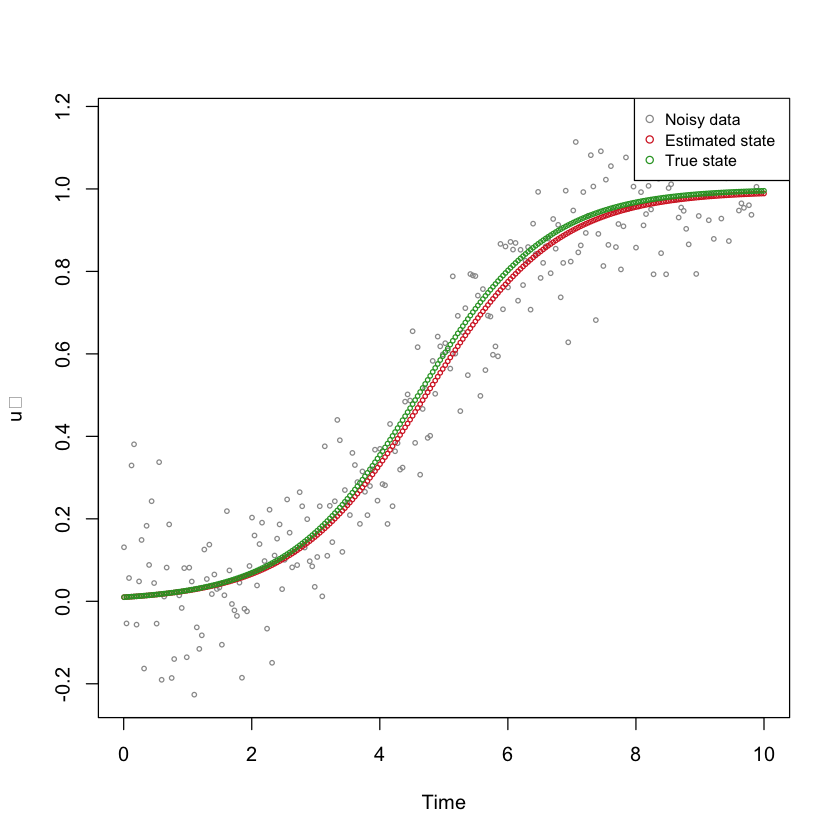

In [6]:
sol_hat <- deSolve::ode(u0, t_eval, modelODE, res$phat)

plot(tt, U, cex = 0.5, xlab = "Time", ylab = "u₁", col = "gray60")
points(tt, sol_hat[,2], cex = 0.5, col = "#d62728")
points(tt, sol[,2], cex = 0.5, col = "#2ca02c")
legend("topright", 
       legend = c("Noisy data", "Estimated state", "True state"),
       col = c("gray60", "#d62728", "#2ca02c"),
       pch = 1,
       cex = 0.8)